In [32]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipynb.fs.defs.train import CharCNN, CaptchaCharDataset, eval_img
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import *




In [2]:
train_dir = os.getcwd() + "/../train"
train_data_dir = os.getcwd() + "/../train_chars"
val_dir = os.getcwd() + "/../test"
val_data_dir = os.getcwd() + "/../test_chars"
model_weights_path = os.path.join(os.getcwd(), '../model/char_cnn.pth')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


val_dataset = CaptchaCharDataset(val_data_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [4]:
device = torch.device("cuda")
model = CharCNN(num_classes=36).to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))  
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

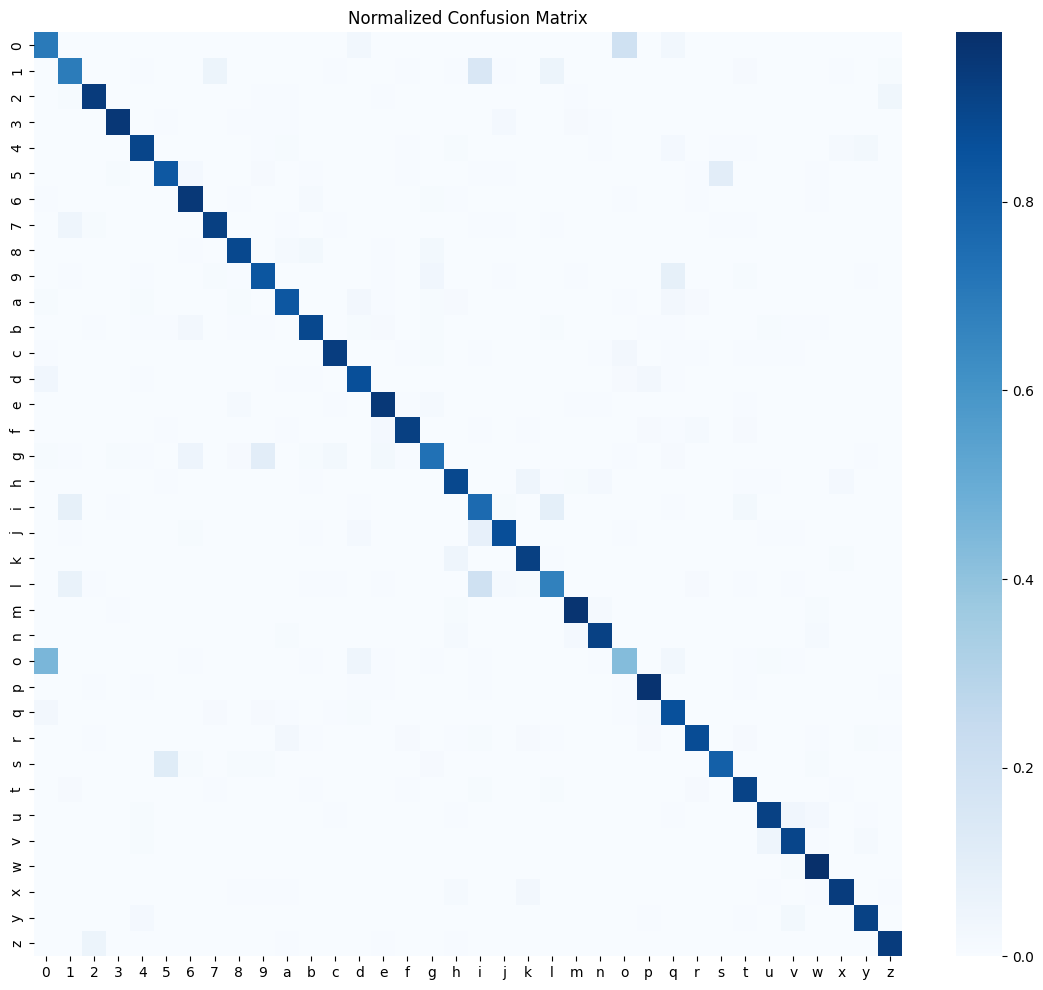

Top 5 most confused pairs (true -> predicted):
o -> 0: 115 times
0 -> o: 53 times
l -> i: 52 times
1 -> i: 36 times
s -> 5: 31 times


In [11]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z')+1)]  # 0–9 + a–z

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.show()

cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Flatten and get top 3 indices
top_indices = np.dstack(np.unravel_index(np.argsort(cm_no_diag.ravel())[-5:], cm_no_diag.shape))[0]

print("Top 5 most confused pairs (true -> predicted):")
for true_idx, pred_idx in reversed(top_indices):
    print(f"{classes[true_idx]} -> {classes[pred_idx]}: {cm[true_idx, pred_idx]} times")

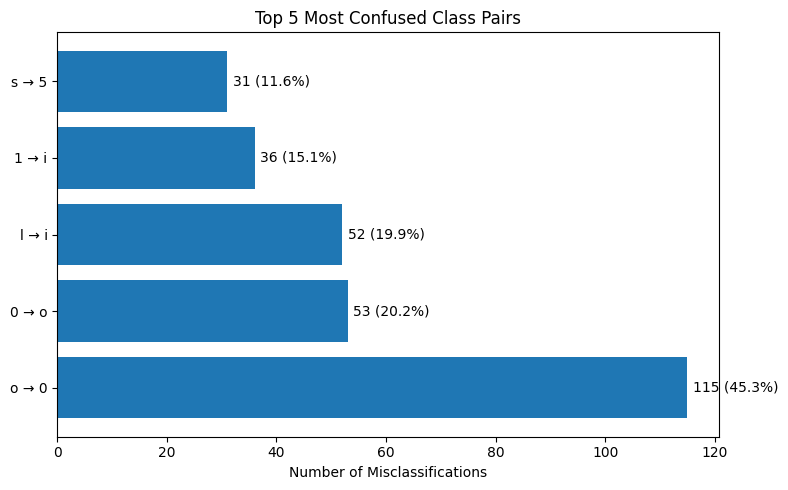

In [27]:
# Flatten and get top N indices
flat_indices = np.argsort(cm_no_diag.ravel())[-5:]
top_indices = [np.unravel_index(idx, cm_no_diag.shape) for idx in flat_indices]
top_indices = top_indices[::-1]  # largest first

# Create DataFrame
rows = []
for true_idx, pred_idx in top_indices:
    count = cm[true_idx, pred_idx]
    total_for_class = cm[true_idx].sum()  # total instances of this true class
    pct = 100 * count / total_for_class if total_for_class > 0 else 0
    rows.append({
        "Pair": f"{classes[true_idx]} → {classes[pred_idx]}",
        "Count": count,
        "Percentage": pct
    })

df = pd.DataFrame(rows)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
bars = plt.barh(df["Pair"], df["Count"])

# Add count and percentage labels
for bar, pct in zip(bars, df["Percentage"]):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{int(width)} ({pct:.1f}%)", va='center', fontsize=10)

plt.xlabel("Number of Misclassifications")
plt.title(f"Top {5} Most Confused Class Pairs")
plt.tight_layout()
plt.show()

In [6]:
print(classification_report(all_labels, all_preds, target_names=classes, digits=2))


              precision    recall  f1-score   support

           0       0.57      0.70      0.63       263
           1       0.72      0.69      0.71       239
           2       0.91      0.94      0.92       235
           3       0.96      0.95      0.95       255
           4       0.91      0.90      0.90       240
           5       0.85      0.83      0.84       239
           6       0.87      0.95      0.90       231
           7       0.91      0.92      0.91       236
           8       0.92      0.89      0.90       262
           9       0.83      0.83      0.83       254
           a       0.89      0.83      0.86       273
           b       0.90      0.89      0.90       249
           c       0.94      0.93      0.93       248
           d       0.84      0.86      0.85       262
           e       0.90      0.95      0.92       248
           f       0.95      0.92      0.94       245
           g       0.84      0.73      0.78       258
           h       0.86    

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# all_true_chars and all_pred_chars collected from your test set
report_dict = classification_report(all_labels, all_preds, target_names=classes, digits=2)

# Convert to DataFrame and remove "accuracy", "macro avg", "weighted avg"
df = pd.DataFrame(report_dict).transpose()
df = df.drop(["accuracy", "macro avg", "weighted avg"], errors='ignore')

# Keep only precision, recall, f1-score
df_metrics = df[["precision", "recall", "f1-score"]]

ValueError: DataFrame constructor not properly called!

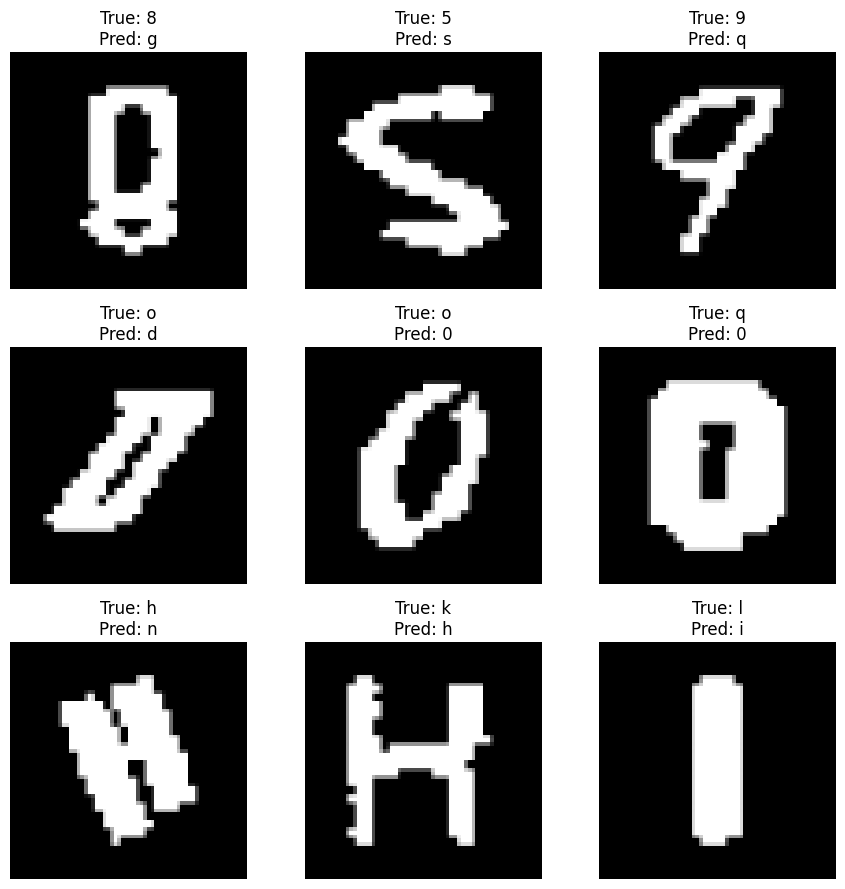

In [7]:
import random

# Convert your dataset back to numpy/PIL images for display
misclassified = np.where(all_preds != all_labels)[0]
samples = random.sample(list(misclassified), 9)

plt.figure(figsize=(9, 9))
for i, idx in enumerate(samples):
    img, label = val_dataset[idx]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {classes[label]}\nPred: {classes[all_preds[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()